In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2, image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    #transforms.Normalize(mean=mean, std=std) #Dataset specific normalisation
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #When you are using pre-trained models that expect inputs normalized with specific values.
])

# Create the dataset
image_dir = r"../../tiff_experiment_unsupervised_data/combined"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


In [5]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


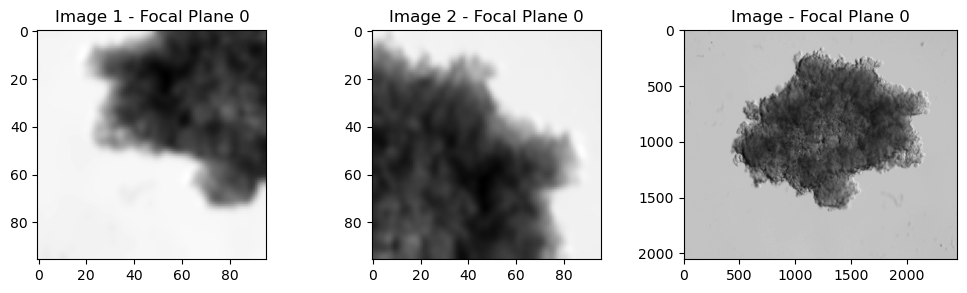

In [6]:
for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first focal plane (layer) for visualization
    layer_to_visualize = 0  # Change this to 1 or 2 if you want other layers
    
    plt.figure(figsize=(10, 3))
    
    # Normalize the 16-bit image to range [0, 1] for visualization
    image1_normalized = image1[0, layer_to_visualize].float()
    image2_normalized = image2[0, layer_to_visualize].float()
    image_normalized = image[0, layer_to_visualize].float()
    
    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1_normalized, cmap='gray')
    plt.title(f'Image 1 - Focal Plane {layer_to_visualize}')
    
    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2_normalized, cmap='gray')
    plt.title(f'Image 2 - Focal Plane {layer_to_visualize}')
    
    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image_normalized, cmap='gray')
    plt.title(f'Image - Focal Plane {layer_to_visualize}')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


In [7]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [8]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.title('Training and Validation Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []
    train_mean_pos, val_mean_pos = [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | Mean Pos: {val_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

    return model

Using device: cuda


Epoch 1/1 | Train Loss: 3.2696 | Top-1 Acc: 0.10% | Top-5 Acc: 0.33% | Mean Pos: 11.05 | Val Loss: 3.0456 | Top-1 Acc: 0.10% | Top-5 Acc: 0.49% | Mean Pos: 8.51 | Time Taken: 31.09 seconds
Total Training Time: 31.09 seconds


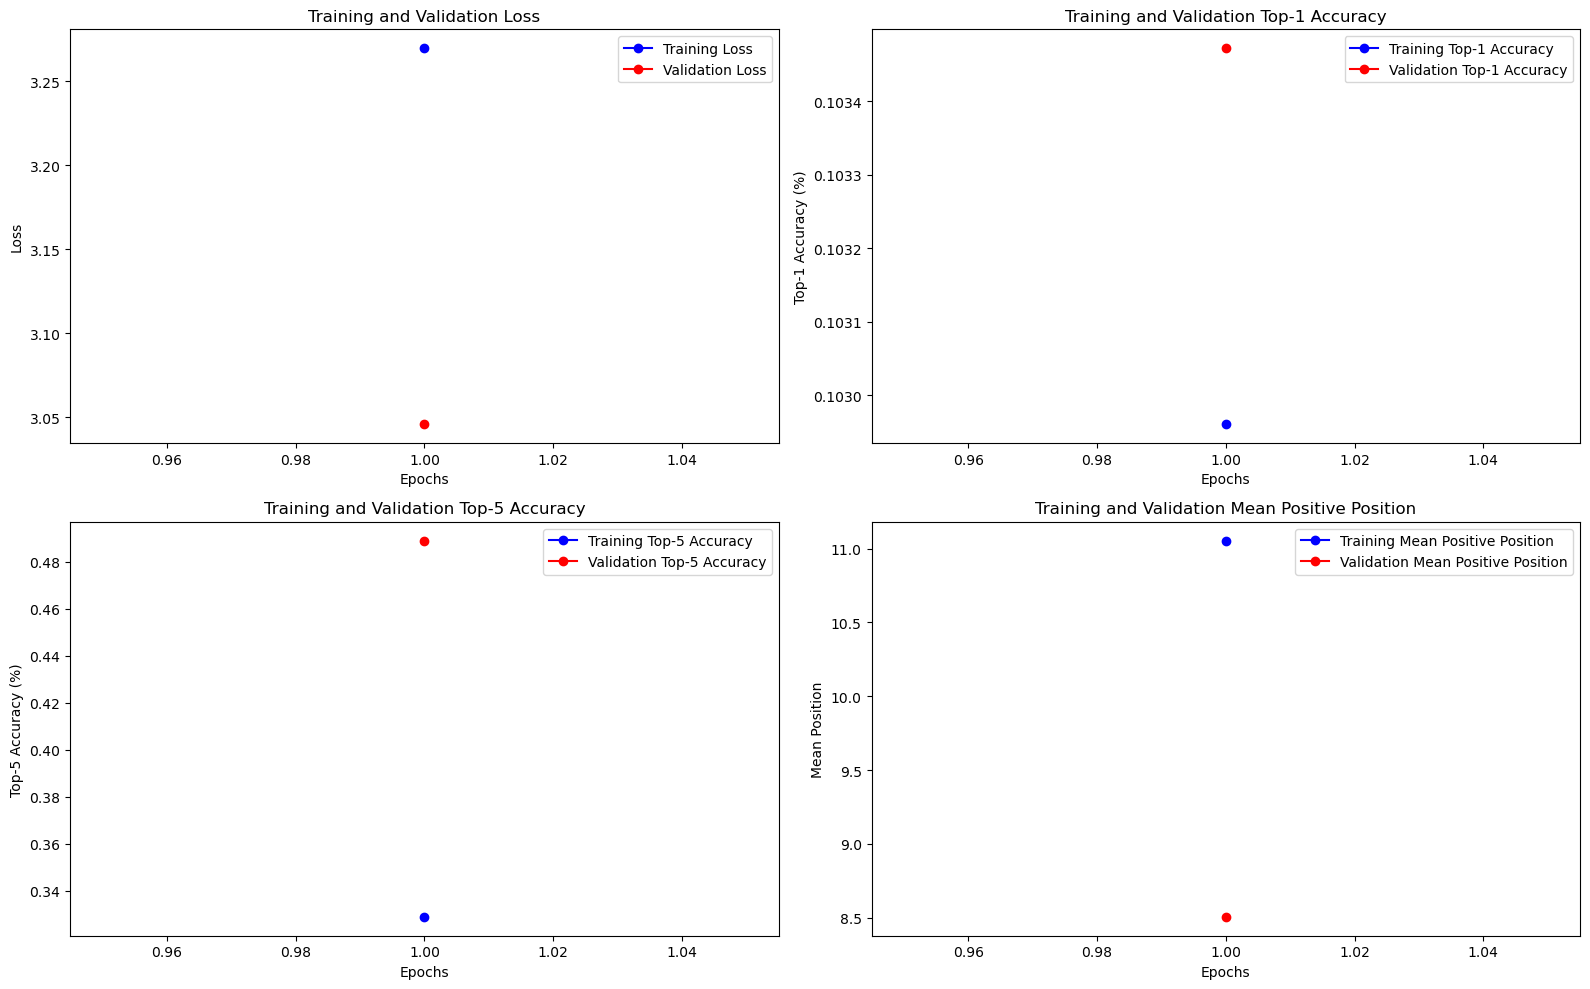

In [11]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=1)

# Logistic

In [12]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"../../Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [13]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0])


In [14]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [15]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.11it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.14it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:02<00:00,  1.14it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Batch features shape: torch.Size([9, 512])
Batch labels shape: torch.Size([9])
Features shape after concatenation: torch.Size([57, 512])
Labels shape after concatenation: torch.Size([57])


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Batch features shape: torch.Size([15, 512])
Batch labels shape: torch.Size([15])
Features shape after concatenation: torch.Size([15, 512])
Labels shape after concatenation: torch.Size([15])


In [16]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [17]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [18]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [19]:
# Main training loop
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)
        
        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict()

    # Load best model state
    model.load_state_dict(best_model_state)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {"train_acc": train_acc, "test_acc": test_acc}

Epoch 1/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 132.58it/s]


Training loss: 0.9245, Training accuracy: 0.5088
Test loss: 0.7845, Test accuracy: 0.8667
Epoch 2/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 110.82it/s]


Training loss: 0.6987, Training accuracy: 0.7719
Test loss: 0.7035, Test accuracy: 0.7333
Epoch 3/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 126.77it/s]


Training loss: 0.6167, Training accuracy: 0.8070
Test loss: 0.6007, Test accuracy: 0.8000
Epoch 4/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.6633, Training accuracy: 0.8070
Test loss: 0.5332, Test accuracy: 0.8000
Epoch 5/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4838, Training accuracy: 0.8070
Test loss: 0.5234, Test accuracy: 0.8667
Epoch 6/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 124.77it/s]


Training loss: 0.4645, Training accuracy: 0.8070
Test loss: 0.5226, Test accuracy: 0.8667
Epoch 7/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5520, Training accuracy: 0.8070
Test loss: 0.5217, Test accuracy: 0.8667
Epoch 8/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 135.66it/s]


Training loss: 0.5566, Training accuracy: 0.8070
Test loss: 0.5208, Test accuracy: 0.8667
Epoch 9/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 606.77it/s]


Training loss: 0.4741, Training accuracy: 0.8070
Test loss: 0.5198, Test accuracy: 0.9333
Epoch 10/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 948.19it/s]


Training loss: 0.4728, Training accuracy: 0.8070
Test loss: 0.5190, Test accuracy: 0.9333
Epoch 11/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 125.14it/s]


Training loss: 0.4728, Training accuracy: 0.8070
Test loss: 0.5183, Test accuracy: 0.9333
Epoch 12/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 241.83it/s]


Training loss: 0.4826, Training accuracy: 0.8070
Test loss: 0.5175, Test accuracy: 0.9333
Epoch 13/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 113.54it/s]


Training loss: 0.5257, Training accuracy: 0.8070
Test loss: 0.5168, Test accuracy: 0.9333
Epoch 14/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 112.33it/s]


Training loss: 0.5029, Training accuracy: 0.8070
Test loss: 0.5160, Test accuracy: 0.9333
Epoch 15/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.12it/s]


Training loss: 0.4585, Training accuracy: 0.8070
Test loss: 0.5151, Test accuracy: 0.9333
Epoch 16/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 137.29it/s]


Training loss: 0.5117, Training accuracy: 0.8070
Test loss: 0.5143, Test accuracy: 0.9333
Epoch 17/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1028.14it/s]


Training loss: 0.5290, Training accuracy: 0.8070
Test loss: 0.5136, Test accuracy: 0.9333
Epoch 18/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4783, Training accuracy: 0.8070
Test loss: 0.5129, Test accuracy: 0.9333
Epoch 19/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.20it/s]


Training loss: 0.5067, Training accuracy: 0.8070
Test loss: 0.5121, Test accuracy: 0.9333
Epoch 20/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.12it/s]


Training loss: 0.4964, Training accuracy: 0.8246
Test loss: 0.5114, Test accuracy: 0.9333
Epoch 21/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 132.29it/s]


Training loss: 0.4676, Training accuracy: 0.8246
Test loss: 0.5106, Test accuracy: 0.9333
Epoch 22/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1385.17it/s]


Training loss: 0.4878, Training accuracy: 0.8246
Test loss: 0.5099, Test accuracy: 0.9333
Epoch 23/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 220.48it/s]


Training loss: 0.4645, Training accuracy: 0.8246
Test loss: 0.5092, Test accuracy: 0.9333
Epoch 24/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.14it/s]


Training loss: 0.5848, Training accuracy: 0.8246
Test loss: 0.5084, Test accuracy: 0.9333
Epoch 25/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 294.66it/s]


Training loss: 0.5335, Training accuracy: 0.8246
Test loss: 0.5073, Test accuracy: 0.9333
Epoch 26/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 106.05it/s]


Training loss: 0.4678, Training accuracy: 0.8421
Test loss: 0.5064, Test accuracy: 0.9333
Epoch 27/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4634, Training accuracy: 0.8421
Test loss: 0.5056, Test accuracy: 0.9333
Epoch 28/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.41it/s]


Training loss: 0.4688, Training accuracy: 0.8421
Test loss: 0.5049, Test accuracy: 0.9333
Epoch 29/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 251.77it/s]


Training loss: 0.5068, Training accuracy: 0.8421
Test loss: 0.5042, Test accuracy: 0.9333
Epoch 30/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 170.89it/s]


Training loss: 0.5379, Training accuracy: 0.8421
Test loss: 0.5034, Test accuracy: 0.9333
Epoch 31/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 129.23it/s]


Training loss: 0.4572, Training accuracy: 0.8421
Test loss: 0.5026, Test accuracy: 0.9333
Epoch 32/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 220.14it/s]


Training loss: 0.4546, Training accuracy: 0.8421
Test loss: 0.5018, Test accuracy: 0.9333
Epoch 33/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 82.52it/s]


Training loss: 0.5031, Training accuracy: 0.8421
Test loss: 0.5011, Test accuracy: 0.9333
Epoch 34/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.61it/s]


Training loss: 0.5751, Training accuracy: 0.8421
Test loss: 0.5003, Test accuracy: 0.9333
Epoch 35/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 125.72it/s]


Training loss: 0.5615, Training accuracy: 0.8421
Test loss: 0.4992, Test accuracy: 0.9333
Epoch 36/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 89.34it/s]


Training loss: 0.5072, Training accuracy: 0.8421
Test loss: 0.4981, Test accuracy: 0.9333
Epoch 37/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 133.85it/s]


Training loss: 0.5230, Training accuracy: 0.8421
Test loss: 0.4972, Test accuracy: 0.9333
Epoch 38/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 211.58it/s]


Training loss: 0.5038, Training accuracy: 0.8421
Test loss: 0.4964, Test accuracy: 0.9333
Epoch 39/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 129.77it/s]


Training loss: 0.4977, Training accuracy: 0.8421
Test loss: 0.4954, Test accuracy: 0.9333
Epoch 40/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 103.85it/s]


Training loss: 0.5377, Training accuracy: 0.8421
Test loss: 0.4946, Test accuracy: 0.9333
Epoch 41/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 89.35it/s]


Training loss: 0.5544, Training accuracy: 0.8421
Test loss: 0.4936, Test accuracy: 0.9333
Epoch 42/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 130.11it/s]


Training loss: 0.4586, Training accuracy: 0.8421
Test loss: 0.4926, Test accuracy: 0.9333
Epoch 43/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 110.29it/s]


Training loss: 0.5518, Training accuracy: 0.8596
Test loss: 0.4918, Test accuracy: 0.9333
Epoch 44/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.89it/s]


Training loss: 0.4551, Training accuracy: 0.8772
Test loss: 0.4909, Test accuracy: 0.9333
Epoch 45/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.57it/s]


Training loss: 0.5933, Training accuracy: 0.8772
Test loss: 0.4902, Test accuracy: 0.9333
Epoch 46/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4960, Training accuracy: 0.8772
Test loss: 0.4893, Test accuracy: 0.9333
Epoch 47/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 108.81it/s]


Training loss: 0.4575, Training accuracy: 0.8772
Test loss: 0.4885, Test accuracy: 0.9333
Epoch 48/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 136.59it/s]


Training loss: 0.4616, Training accuracy: 0.8772
Test loss: 0.4879, Test accuracy: 0.9333
Epoch 49/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.79it/s]


Training loss: 0.4813, Training accuracy: 0.8772
Test loss: 0.4873, Test accuracy: 0.9333
Epoch 50/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4559, Training accuracy: 0.8772
Test loss: 0.4867, Test accuracy: 0.9333


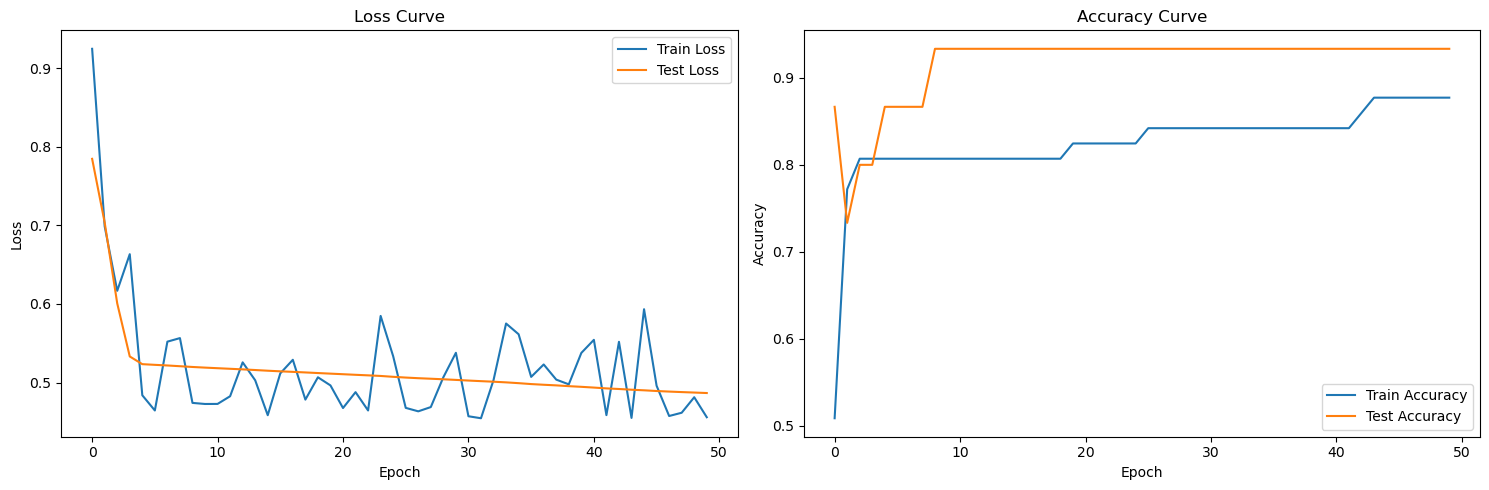

In [20]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=50
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")
